# Trying Regression Algorithm using various methods

This Notebook epxeriments with various Regression Model implementations.

The goal is to test:
1. Use dataset as-is
2. Apply scaling to all rows: The error-results for 1 and 2 should be same.
3. Remove correlated columns > 0.5
4. With each column removed. 

The data-set will be divided into 
1. Training set (80%) - 20%
2. Train using all and still test (over fitting)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from gradient_descent_np import GradientDescentNumpy
from gradient_descent_torch import GradientDescentTorch
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import time
import seaborn as sns

In [2]:
# Helps to print the output to the console of the import statements
import sys
stdout = sys.stdout

# DataSet


Create following data:
1. X, Y: Whole dataset
2. X_S, Y_X: Scaled (standard) datasets
3. X_train, X_test, Y_train, Y_test original non-scaled data
4. X_train_S, Y_Train_S, Y_train_S, Y_test_S scaled test and Train datasets



In [3]:
# Import dataset for regression
ca_housing = fetch_california_housing()
X = ca_housing.data.astype(np.float32)
Y = ca_housing.target.reshape(-1,1).astype(np.float32)

# Normalize the data using zscale, use separate scaler for X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_S = scaler_X.fit_transform(X)
Y_S = scaler_Y.fit_transform(Y.reshape(-1, 1))

In [4]:
# Create X_Train and X_Test for all X, X_S, Y, Y_S
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_S, Y_S, test_size=0.2, random_state=42)

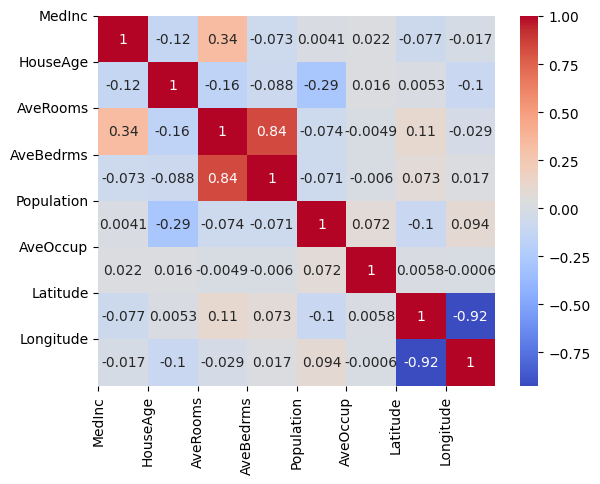

In [5]:
# Get the correlation matrix of the features
corr_matrix = np.corrcoef(X_train.T)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# SHow column names in the heatmap, at center of row
plt.xticks(range(X_train.shape[1]), ca_housing.feature_names, rotation=90)
plt.yticks(range(X_train.shape[1]), ca_housing.feature_names, rotation=0)
plt.show()

In [6]:
# Print columns names that are highly correlated with the target)
np_feature_names = np.array(ca_housing.feature_names)
delete_candidate_features = []
for i, col in enumerate(np_feature_names):
    correlated_features = abs(corr_matrix[i,i+1:]) > 0.5
    if correlated_features.sum() >= 1:
        print(f"CORR: {col} => {np_feature_names[i+1:][correlated_features]}")
        delete_candidate_features.append((i, col))
print(f"delete_candidate_features: {delete_candidate_features}")

CORR: AveRooms => ['AveBedrms']
CORR: Latitude => ['Longitude']
delete_candidate_features: [(2, np.str_('AveRooms')), (6, np.str_('Latitude'))]


In [7]:
delete_candidate_features_indices = [i for i, _ in delete_candidate_features]
np_feature_names = np.delete(
    np_feature_names, delete_candidate_features_indices)

# Remove "AveBedrms", "Longitude" from the X_train and X_test
X_train_deleted = np.delete(X_train, delete_candidate_features_indices, axis=1)
X_test_deleted = np.delete(X_test, delete_candidate_features_indices, axis=1)

# Print the shape of the X_train and X_test
print(X_train.shape, X_test.shape)

(16512, 8) (4128, 8)


# Custom Gradient Descent
The basic algorithm implemented:
<pre>
Input:
    X := m x n matrix (m: features, n:training samples)
    y := m x 1 vector (targets)

Initialize:
    W := (n+1) x 1 params (bias+weights), vector of zeros (or small random numbers)

Preprocess:
    X:= Add a column of 1s to X for the bias term

Loop (for num_iters):
    predictions := X ⋅ W
    errors := predictions - y
    gradients := (1/m) ⋅ X.T ⋅ errors
    delta_W = alpha ⋅ gradients
    if norm(delta_W) < tolerance:
        done
    W := W - delta_W
</pre>

It is implemented two ways using:
1. NumPy: vectors [](./gradient_descent_np.py)
2. PyTorch to take advantage of Mac Performance Shaders "MPS".

The PyTorch version took significantly longer. Have not investigated the reason yet.

In [8]:
# Global variables
max_iter = 20_000_000
tolerance = 1e-7
learning_rate = 0.0001

## Option 1: Train without scaling
Use X_Train and Y_Train and measure the error

In [9]:
# Now train the model
m_x = GradientDescentNumpy(learning_rate, max_iter, tolerance, max_tolerance=1e7)
time_taken, iter_count, converged = m_x.descent(X_train, y_train)
print(f"time_taken: {time_taken}, iter_count: {iter_count}, converged: {converged}")
print(f"params: {m_x.params.reshape(1, -1)}")

X: (16512, 8), y: (16512,)
No convergence: 10800803.0 [[ 4.6320049e+03  1.8004441e+04  1.1898677e+05  2.4529240e+04
   4.9664067e+03  1.0784659e+07  1.7422818e+04  1.6429533e+05
  -5.5321169e+05]]
time_taken: 0.0010589169978629798, iter_count: 3, converged: 10800803.0
params: [[ 1.3878620e+01  5.3946159e+01  3.5651450e+02  7.3495766e+01
   1.4880588e+01  3.2313199e+04  5.2202797e+01  4.9227014e+02
  -1.6575582e+03]]


In [10]:
# Now train the model on scaled data
m_xs = GradientDescentNumpy(learning_rate, max_iter, tolerance)
time_taken, iter_count, converged = m_xs.descent(X_train_S, y_train_S)
print(
    f"time_taken: {time_taken}, iter_count: {iter_count}, converged: {converged}")
print(f"params: {m_x.params.reshape(1, -1)}")

X: (16512, 8), y: (16512,)
time_taken: 30.76721012499911, iter_count: 666245, converged: 9.999991590348145e-08
params: [[ 1.3878620e+01  5.3946159e+01  3.5651450e+02  7.3495766e+01
   1.4880588e+01  3.2313199e+04  5.2202797e+01  4.9227014e+02
  -1.6575582e+03]]


In [11]:
# Train using standard Linear Regression on sklearn
sklearn_model = LinearRegression()
result =sklearn_model.fit(X_train, y_train)
# Print the coefficients
print(f"coefficients: {sklearn_model.coef_}")
print(f"intercept: {sklearn_model.intercept_}")

coefficients: [[ 8.6773813e-02  1.7863633e-02  1.5948147e-01  2.0887107e-02
   4.7514255e-05 -2.9400256e-03 -2.9956346e-02  2.9687775e-02]]
intercept: [4.8936205]


In [12]:
# Train using standard Linear Regression on scaled data
sklearn_model_s = LinearRegression()
result_s = sklearn_model_s.fit(X_train_S, y_train_S)
# Print the coefficients
print(f"coefficients: {sklearn_model_s.coef_}")
print(f"intercept: {sklearn_model_s.intercept_}")


coefficients: [[ 0.73867834  0.10605712 -0.26441497  0.32162473 -0.00199158 -0.03173809
  -0.7770289  -0.7530168 ]]
intercept: [-0.00060301]


error: 3328.964599609375


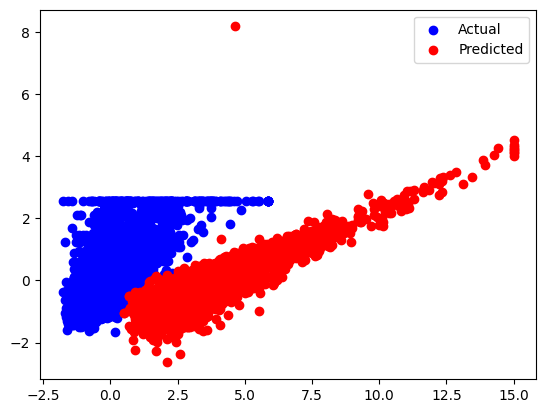

In [13]:
# Now predict the model
y_pred, time_taken = m_xs.predict(X_test_S)
error = 1/(2*len(X_test_S))*np.sum((y_test_S - y_pred)**2)
print(f"error: {error}")
# Plot the predicted values
plt.scatter(X_test_S[:, 0], y_test_S, color='blue', label='Actual')
plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted')
plt.legend()
plt.show()

# Plot the predicted values

# Use the  PyTorch model

In [14]:
X_train_pytorch = torch.tensor(X_train, dtype=torch.float32)
Y_train_pytorch = torch.tensor(y_train, dtype=torch.float32)
torch_model = GradientDescentTorch(learning_rate=0.0001, max_iter=20_000_000, tolerance=1e-8)
time_taken, iter_count, converged = torch_model.descent(
    X_train_pytorch, Y_train_pytorch)
print(f"time_taken: {time_taken}, iter_count: {iter_count}, converged: {converged}")

Will not converge: tensor([[ 1.3920e+01],
        [ 5.4108e+01],
        [ 3.5758e+02],
        [ 7.3716e+01],
        [ 1.4925e+01],
        [ 3.2410e+04],
        [ 5.2360e+01],
        [ 4.9375e+02],
        [-1.6625e+03]], device='mps:0')
time_taken: 0.12390174999745796, iter_count: 2, converged: inf


In [15]:
for i, param in enumerate(torch_model.params):
    print(f"param {i}: {param.item()}")

param 0: -0.04159800335764885
param 1: -0.16138698160648346
param 2: -1.067500352859497
param 3: -0.22015930712223053
param 4: -0.04459938779473305
param 5: -97.10848999023438
param 6: -0.15671323239803314
param 7: -1.4754934310913086
param 8: 4.968096733093262


In [16]:
# sklearn
from sklearn.linear_model import LinearRegression
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)
# Print the coefficients
print(f"coefficients: {sklearn_model.coef_}")
print(f"intercept: {sklearn_model.intercept_}")

coefficients: [[ 8.6773813e-02  1.7863633e-02  1.5948147e-01  2.0887107e-02
   4.7514255e-05 -2.9400256e-03 -2.9956346e-02  2.9687775e-02]]
intercept: [4.8936205]


In [17]:
y_pred = sklearn_model.predict(X_test)
error = 1/(2*len(X_test))*np.sum((y_test - y_pred)**2)
print(f"error: {error}")

error: 0.5730289220809937


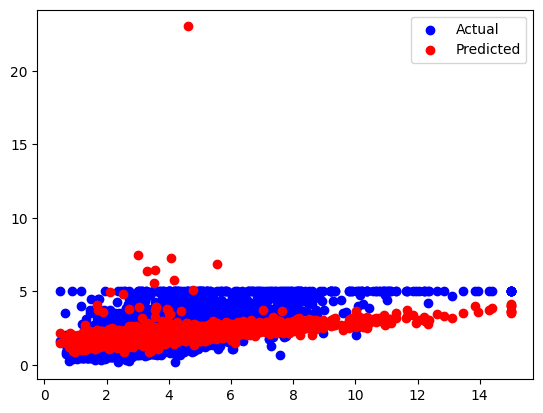

In [18]:
# Plot the predicted values
plt.scatter(X_test[:, 0], y_test, color='blue', label='Actual')
plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted')
plt.legend()
plt.show()
